In [1]:
import random
import itertools
import functools
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import gudhi as gd
import torch
import torch.nn as nn

def rand(shape, low, high):
    """Tensor of random numbers, uniformly distributed on [low, high]."""
    return torch.rand(shape) * (high - low) + low

def count_parameters(model):
    """Return the number of trainable parameters of a model (the total number of scalars)."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
# I WANT TO COMPARE POINT WITH 1K POINTS WITH THE SAME STARTING POINT
def generate_orbits(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], same_init_point = True):
    # create point clouds 
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    return ORBITS

# function from [len(params), n_points, 2] to alpha-complex and persistence diagram
# to create PDs we need to: points -> skeleton(ac) -> simplex(st) -> persistence(pers)
# for each element of the dataset we'll have len(params) PDs to be compared
import gudhi as gd
def extract_PD(cloud, id_class):
    """extract a dict 

    Args:
        cloud (_type_): array [1000,2] composing th ewhole point cloud
        id_class (_type_): index about the class of membership

    Returns:
        dict: with keys ['persist_0','persist_1','id_class']
    """
    # for every point cloud we create a dictionary storing the label and its persistence
    # usage of dictionary to store each other possible data linked to the point clous
    ac = gd.AlphaComplex(points=cloud)
    st = ac.create_simplex_tree()
    pers = st.persistence()
    #? EXTENDED PERSISTENCE?
    #! TRANSPOSE TO HAVE THEN [BATCH SIZE, 2, NUM POINTS]
    pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()#*100
    pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()#*100
    pers_dict = {
        'cloud': cloud, #* UNCOMMENT THE LINE IF YOU WANT TO VISUALIZE POINT CLOUDS LATER
        # 'skeleton': ac, # no more used
        # 'complex': st, # used for bottleneck distance
        'persist_0': pers_0[:,:-1], # removing the last barcode, the one with inf
        'persist_1': pers_1, # here we should never have inf, since [0,1]^2 is compact/bounded  
        # 'persist': pers, # actual PD
        'id_class': id_class # label for classification
    }
    return pers_dict

# def pd_to_tensor(pd, value):
#     # tens_intervals = torch.tensor([list(tp[1]) for tp in pd ])
#     tens_intervals = torch.tensor(pd).float()
#     # this tensor can contain float('inf)
#     tens_intervals[torch.isinf(tens_intervals)] = value
#     return tens_intervals

def preproc_prom(tens, prom):
    diff = tens[1] - tens[0]
    sort_diff = torch.argsort(diff, descending=True)
    sort_tens = tens[:,sort_diff]
    return sort_tens[:,:prom]

In [3]:
### FULL DATA GENERATION 
# (~2 mins) ---------------------------------------

# hyper params
n_points = 1000
params = [2.5, 3.5, 4.0, 4.1, 4.3]
same_init_point = True
n_seq_per_dataset = [700, 300] # I want [i, len(params), n_points, 2]

batch_size = 128
extended_pers = False
k_pd_preproc = 500

# init list fo persistence diagrams
pds_train = []
pds_test = []

# TRAIN 
for i in tqdm(range(n_seq_per_dataset[0]), desc='Create TRAIN Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_train.append(ij_pers) # STORE IN THE LIST pds_train

train_batched_data = [] # BATCHING DATA FOR THE NN
batching = len(pds_train)//batch_size
for i in range(batching):
    train_batched_data.append(pds_train[i*batch_size:(i+1)*batch_size])
# check if we have to add the last batch
if batching*batch_size != len(pds_train):
    train_batched_data.append(pds_train[batching*batch_size:])
print(f'{len(train_batched_data) = }\n')
    

# TEST
for i in tqdm(range(n_seq_per_dataset[1]), desc='Create TEST Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_test.append(ij_pers) # STORE IN THE LIST pds_test

test_batched_data = [] # BATCHING DATA FOR THE NN
batching = len(pds_test)//batch_size
for i in range(batching):
    test_batched_data.append(pds_test[i*batch_size:(i+1)*batch_size])
# check if we have to add the last batch
if batching*batch_size != len(pds_test):
    test_batched_data.append(pds_test[batching*batch_size:])
print(f'{len(test_batched_data) = }')

Create TRAIN Point Clouds: 100%|██████████| 700/700 [00:33<00:00, 20.82it/s]


len(train_batched_data) = 28



Create TEST Point Clouds: 100%|██████████| 300/300 [00:15<00:00, 18.84it/s]

len(test_batched_data) = 12


In [4]:
###### CHECK

# check the order of persistences; BRUTE FORCE: expecting 4 {False}
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_0']]) for l in pds_train ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_1']]) for l in pds_train ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_0']]) for l in pds_test ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_1']]) for l in pds_test ]; print(set(contains_inf))

dims = [sample['persist_1'].shape[1] for sample in pds_train]
level_to_check = [1,100,200,300,400,500,600,700,800,900,1000,1025]
for level in level_to_check:
    print(f'level = {level:^4} => num of barcodes = {len([x for x in dims if x <= level])}')

{False}
{False}
{False}
{False}
level =  1   => num of barcodes = 27
level = 100  => num of barcodes = 57
level = 200  => num of barcodes = 59
level = 300  => num of barcodes = 64
level = 400  => num of barcodes = 69
level = 500  => num of barcodes = 74
level = 600  => num of barcodes = 77
level = 700  => num of barcodes = 77
level = 800  => num of barcodes = 87
level = 900  => num of barcodes = 1049
level = 1000 => num of barcodes = 3489
level = 1025 => num of barcodes = 3500


In [5]:
class DeepSetLayer(nn.Module):
    """
    DeepSetLayer(in_blocks, out_blocks) takes shape (batch, in_blocks, n) to (batch, out_blocks, n).
    Each block of n scalars is treated as the S_n permutation representation, and maps between blocks are
    S_n-equivariant.
    """
    def __init__(self, in_blocks, out_blocks):
        super().__init__()
        
        self.in_blocks = in_blocks
        self.out_blocks = out_blocks
        
        # Initialisation tactic copied from nn.Linear in PyTorch
        lim = (in_blocks)**-0.5 / 2

        # Alpha corresponds to the identity, beta to the all-ones matrix, and gamma to the additive bias.
        self.alpha = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.beta = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.gamma = torch.nn.Parameter(data=rand((out_blocks), -lim, lim))
    
    def forward(self, x):
        # x has shape (batch, in_blocks, n)
        return (
            torch.einsum('...jz, ij -> ...iz', x, self.alpha)
            + torch.einsum('...jz, ij -> ...iz', x.max(axis=-1)[0][..., None], self.beta)
            + self.gamma[..., None]
        )

In [6]:
class Perslay_KTH(nn.Module):
    def __init__(self, hidden_size:int = 10, alpha_0:bool = True, alpha_1:bool = True, prom:int = 500, top_k:int = 5, using_len_p1:bool = False):
        super().__init__()
        self.a0 = alpha_0
        self.a1 = alpha_1
        self.prom = prom
        self.top_k = top_k
        self.num_classes = 5
        self.using_len_p1 = using_len_p1

        self.ds_0_a = DeepSetLayer(2,25)
        self.relu_0 = torch.nn.ReLU()
        self.ds_0_b = DeepSetLayer(25,hidden_size)
        # self.ds_0_c = DeepSetLayer(10,5)

        self.ds_1_a = DeepSetLayer(2,25)
        self.relu_1 = torch.nn.ReLU()
        self.ds_1_b = DeepSetLayer(25,hidden_size)
        # self.ds_1_c = DeepSetLayer(10,5)

        if using_len_p1:
            self.linear_dim_H1 = nn.Linear(1,self.top_k)
            self.linear_labels = nn.Linear(self.top_k*(hidden_size*2+1), self.num_classes)
        else:
            self.linear_labels = nn.Linear(self.top_k*(hidden_size*2), self.num_classes)
        
        self.name = f'{hidden_size}_{alpha_0}_{alpha_1}_{prom}_{top_k}_{using_len_p1}' # list of params


    def forward(self, batch_pers_0, batch_pers_1):
        labels = False
        for p0, p1 in zip(batch_pers_0, batch_pers_1):# one PD at the time due to different cardinality betweeen different H1 barcodes
            # I want to select the self.prom longest barcodes
            p0 = torch.tensor(p0)*100 #? rescsaling
            p0 = preproc_prom(p0, self.prom)
            p0 = self.ds_0_a(p0.float())
            p0 = self.ds_0_b(p0)
            p0, _ = torch.topk(p0, self.top_k, dim=1)

            # same for p1
            p1 = torch.tensor(p1)*100 # not always with same len of p0

            p1_shape = p1.shape[1] # number of elemnts in H1 persistence
            if p1_shape<self.top_k:
                dim_to_add = self.top_k - p1_shape
                aux_zeros = torch.zeros(p1.size(0), dim_to_add)
                p1 = torch.cat((p1, aux_zeros), dim=1)

            p1 = preproc_prom(p1, self.prom)
            p1 = self.ds_1_a(p1.float())
            p1 = self.ds_1_b(p1)
            try:
                p1, _ = torch.topk(p1, self.top_k, dim=1)
            except RuntimeError:
                raise ValueError('')
            
            if self.using_len_p1 == True:
                emb_len = self.linear_dim_H1(torch.tensor([p1_shape]).float())
                concat = torch.cat((p0.view(-1), p1.view(-1), emb_len.view(-1)))
            else:
                concat = torch.cat((p0.view(-1), p1.view(-1)))

            labs = self.linear_labels(concat).unsqueeze(0)

            if isinstance(labels,bool):
                labels = labs
            else:
                labels = torch.cat((labels, labs), dim = 0)
                
        return labels

In [7]:
def test_model(model, test_data, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # for batch in tqdm(test_data):
        for batch in test_data:
            batch_in_pd0 = [sample['persist_0'] for sample in batch] # get tersor of persistence
            batch_in_pd1 = [sample['persist_1'] for sample in batch] # get tersor of persistence
            batch_target = torch.tensor([sample['id_class'] for sample in batch]) # get target labels

            # Forward pass
            outputs = model(batch_in_pd0, batch_in_pd1)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += batch_target.size(0)
            # Total correct predictions
            correct += (predicted == batch_target).sum().item()
            target_labs = np.append(target_labs, batch_target)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

In [16]:
# {hidden_size}_{alpha_0}_{alpha_1}_{prom}_{topk}_{using_len_p1}
params_combs = [[25, True, True, 500, 500, False],
                [25, True, True, 500, 500, True],
                [25, True, True, 750, 750, False],
                [25, True, True, 750, 750, True],
                [25, True, True, 250, 250, False],
                [25, True, True, 250, 250, True]                
                ]

In [17]:
import random
from torch.optim.lr_scheduler import StepLR


# Learning rate and loss function.
loss_function = nn.CrossEntropyLoss()
epochs = 300
# recorded_loss = torch.zeros(epochs)

for comb in params_combs:

    model = Perslay_KTH(hidden_size = comb[0], alpha_0 = (comb[1]==bool('True')), alpha_1 = (comb[2]==bool('True')), \
                        prom = comb[3], top_k = comb[4], using_len_p1 = (comb[5]==bool('True')))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # scheduler = StepLR(optimizer, step_size=70, gamma=0.7)
    save_name = model.name
    save_folder = f'./Perslay_models/{save_name}_'

    print(f'##########################\n {save_name} STARTED')
    best_acc = 0.0 

    for epoch in range(epochs):
        model.train()

        total_loss = 0.0
        # for batch in tqdm(train_batched_data):
        for batch in train_batched_data:

            batch_in_pd0 = [sample['persist_0'] for sample in batch] # get tersor of persistence

            batch_in_pd1 = [sample['persist_1'] for sample in batch] # get tersor of persistence

            batch_target = torch.tensor([sample['id_class'] for sample in batch]) # get target labels
            # print(f'\n{len(batch_in_pd0) = }\n{len(batch_in_pd1) = }\n{batch_target.shape = }')

            optimizer.zero_grad()
            result = model(batch_in_pd0, batch_in_pd1)
            loss = loss_function(result, batch_target)
            total_loss += float(loss)
            loss.backward()
            optimizer.step()
            # scheduler.step()
        
        # print(f"Epoch {epoch+1}/{epochs}, loss {total_loss}", end = '')

        test_acc = test_model(model, test_batched_data, if_plot=False)
        if best_acc < test_acc:
            if test_acc > 86.0:
                torch.save(model.state_dict(), save_folder + f'acc_{test_acc:.3f}.pth')
            print(f'\rEpoch {epoch+1}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t', end = '')
            best_acc = test_acc
        else:
            # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
            pass
    print(f'\n> {save_name} FINISHED: final best test accuracy = {best_acc:.3f}\n')
    torch.save(model.state_dict(), save_folder + f'acc_{test_acc:.3f}_LAST.pth')

##########################
 25_True_True_500_500_False STARTED
Epoch 1/300 --> IMPROVEMENT from 0.000 to 71.400
Epoch 2/300 --> IMPROVEMENT from 71.400 to 73.067
Epoch 3/300 --> IMPROVEMENT from 73.067 to 73.533
Epoch 4/300 --> IMPROVEMENT from 73.533 to 75.800
Epoch 5/300 --> IMPROVEMENT from 75.800 to 77.133
Epoch 6/300 --> IMPROVEMENT from 77.133 to 79.333
Epoch 7/300 --> IMPROVEMENT from 79.333 to 80.667
Epoch 8/300 --> IMPROVEMENT from 80.667 to 81.333
Epoch 9/300 --> IMPROVEMENT from 81.333 to 82.133
Epoch 10/300 --> IMPROVEMENT from 82.133 to 83.933
Epoch 17/300 --> IMPROVEMENT from 83.933 to 84.667
Epoch 18/300 --> IMPROVEMENT from 84.667 to 85.133
Epoch 19/300 --> IMPROVEMENT from 85.133 to 85.533
Epoch 20/300 --> IMPROVEMENT from 85.533 to 85.600
Epoch 22/300 --> IMPROVEMENT from 85.600 to 85.867
Epoch 25/300 --> IMPROVEMENT from 85.867 to 86.667
Epoch 26/300 --> IMPROVEMENT from 86.667 to 87.000
Epoch 27/300 --> IMPROVEMENT from 87.000 to 87.067
Epoch 101/300 --> IMPROVEMENT

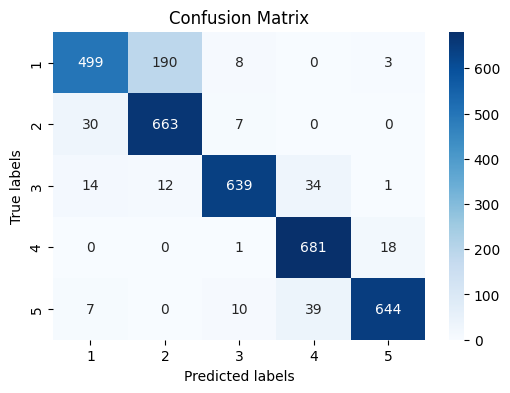

train_acc = 89.31428571428572


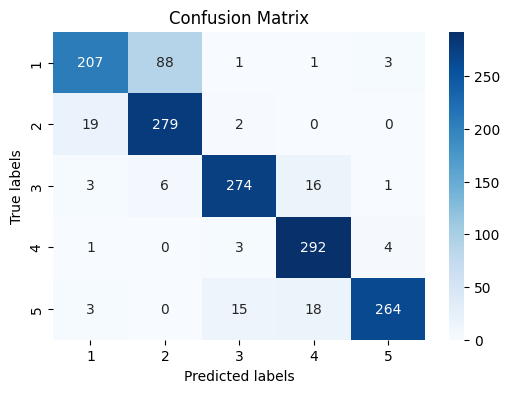

test_acc = 87.73333333333333


In [11]:
# model_str = './Perslay_models/25_True_True_500_10_False_acc_88.13333.pth'
# params = model_str.split('/')[-1].split('_')[:6]
# model = Perslay_KTH(hidden_size=int(params[0]), alpha_0=bool(params[1]), alpha_1=bool(params[2]), prom=int(params[3]), top_k=int(params[4]), using_len_p1=False)
# saved_params = torch.load(model_str)
# model.load_state_dict(saved_params)
train_acc = test_model(model, train_batched_data, if_plot=True); print(f'{train_acc = }')
test_acc = test_model(model, test_batched_data, if_plot=True); print(f'{test_acc = }')